In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

import datetime
import json
import requests

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 6)})

In [2]:
# ref 
# https://github.com/100trillionUSD/bitcoin
# https://github.com/hamal03/btc-s2f/blob/master/cherrypick.py
# https://github.com/8go/bitcoin-stock-to-flow/blob/master/s2f.py

def get_data_from_coinmetrics():
    cmurl = "https://community-api.coinmetrics.io/v2/assets/btc/metricdata"
    cmapistr = '?metrics=PriceUSD%2CSplyCur%2CBlkCnt&start=2009-01-01'
    cmdata = requests.get(cmurl+cmapistr)
    jdata = json.loads(cmdata.text)
    return jdata

rawdata = get_data_from_coinmetrics()

In [44]:

columns = rawdata['metricData']['metrics']

def myparse(row):
    date = datetime.datetime.strptime(row['time'],'%Y-%m-%dT%H:%M:%S.%fZ').date()
    mydict = {'date':date}
    for n,k in enumerate(columns):
        val = row['values'][n]
        val = float(val) if val is not None else np.nan
        mydict[k]=val
    return mydict

S2F_FORMULA = '0.18*s2f^3.3'
def s2f_func(ii, df,ratio=False):
    x_df = df.iloc[ii]
    supply_before = x_df.SplyCur[0]
    supply_now = x_df.SplyCur[-1]
    stock_to_flow_ratio = supply_before / ((supply_now-supply_before)/period*365)
    if ratio:
        return stock_to_flow_ratio
    else:
        ## conservative formula: 0.18*s2f^3.3
        stock_to_flow_usd = 0.18 * stock_to_flow_ratio ** 3.3
        return stock_to_flow_usd
    
df = pd.DataFrame([myparse(x) for x in rawdata['metricData']['series'] ])
df['ii'] = range(len(df))
df.index  = df.date

period = 365
res = df.ii.rolling(period).apply(lambda x: s2f_func(x, df, True))
df['s2f'] = res.values
res = df.ii.rolling(period).apply(lambda x: s2f_func(x, df, False))
df['s2f_usd'] = res.values


In [4]:
print(df.shape)
print(df.head())

(4405, 7)
                  date  PriceUSD  SplyCur  BlkCnt  ii  s2f  s2f_usd
date                                                               
2009-01-03  2009-01-03       NaN      0.0     0.0   0  NaN      NaN
2009-01-04  2009-01-04       NaN      0.0     0.0   1  NaN      NaN
2009-01-05  2009-01-05       NaN      0.0     0.0   2  NaN      NaN
2009-01-06  2009-01-06       NaN      0.0     0.0   3  NaN      NaN
2009-01-07  2009-01-07       NaN      0.0     0.0   4  NaN      NaN


In [5]:
daily_block_count = df.BlkCnt.mean()

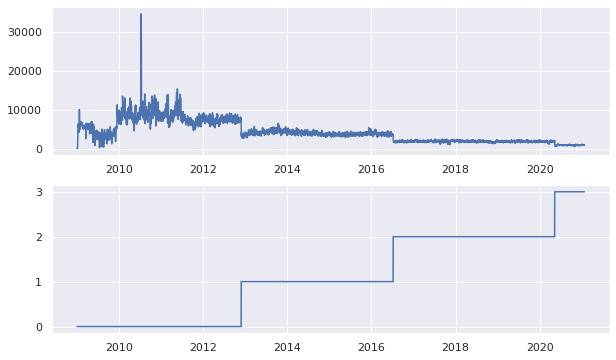

In [35]:
# https://gist.github.com/leto/a8818202ca4298cc3df5cb80b0aeaf82
nSubsidyHalvingInterval = 210000
plt.title('visualizing btc mined every day and each halving')
plt.subplot(211)
plt.plot(df.SplyCur.diff(1))
plt.subplot(212)
plt.plot(df.BlkCnt.cumsum()//nSubsidyHalvingInterval)

In [10]:
# derive BlkCnt, SplyCur
numdays = 365*10 # predict next x days
base = datetime.datetime.today()-datetime.timedelta(days=1)
date_list = [(base+ datetime.timedelta(days=x)).date() for x in range(numdays)]
dff = pd.DataFrame()
dff['date']=date_list
dff.index = dff.date
median_block_count = df.BlkCnt.median()
print(median_block_count)
dfm = pd.concat([df,dff],axis=0)
dfm['ii'] = range(len(dfm))
dfm.BlkCnt = dfm.BlkCnt.fillna(value=median_block_count)
dfm['halving']=dfm.BlkCnt.cumsum()//nSubsidyHalvingInterval
dfm['production']=dfm.SplyCur.diff(1)

152.0


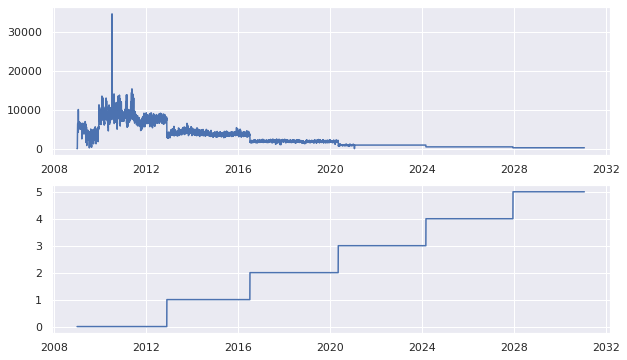

In [34]:
plt.title('visualizing btc mined every day and each halving')
plt.subplot(211)
plt.plot(dfm.SplyCur.diff(1))
plt.subplot(212)
plt.plot(dfm.BlkCnt.cumsum()//nSubsidyHalvingInterval)

In [12]:
# naive ugly esimate with 
for n,row in dfm.iterrows():
    if np.isnan(row.SplyCur):
        yesterday = n-datetime.timedelta(days=1)
        yesterday_row = dfm[dfm.date==yesterday]
        estimated_production = np.nanmedian(dfm[dfm.halving==row.halving].production)
        if np.isnan(estimated_production):
            estimated_production = 0.5*np.nanmedian(dfm[dfm.halving==row.halving-1].production)
        dfm.at[n,'production'] = estimated_production
        dfm.at[n,'SplyCur'] = yesterday_row.SplyCur[0]+estimated_production

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [13]:
res = dfm.ii.rolling(period).apply(lambda x: s2f_func(x, dfm, True))
dfm['s2f'] = res.values
res = dfm.ii.rolling(period).apply(lambda x: s2f_func(x, dfm, False))
dfm['s2f_usd'] = res.values

In [14]:
dfm

,date,PriceUSD,SplyCur,BlkCnt,ii,s2f,s2f_usd,halving,production
date,,,,,,,,,
2009-01-03,2009-01-03,NaN,0.000000e+00,0.0,0,NaN,NaN,0.0,NaN
2009-01-04,2009-01-04,NaN,0.000000e+00,0.0,1,NaN,NaN,0.0,0.000000
2009-01-05,2009-01-05,NaN,0.000000e+00,0.0,2,NaN,NaN,0.0,0.000000
2009-01-06,2009-01-06,NaN,0.000000e+00,0.0,3,NaN,NaN,0.0,0.000000
2009-01-07,2009-01-07,NaN,0.000000e+00,0.0,4,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
2031-01-17,2031-01-17,NaN,2.054479e+07,152.0,8050,244.732674,1.373903e+07,5.0,229.687496
2031-01-18,2031-01-18,NaN,2.054502e+07,152.0,8051,244.735422,1.373954e+07,5.0,229.687496
2031-01-19,2031-01-19,NaN,2.054525e+07,152.0,8052,244.738169,1.374004e+07,5.0,229.687496


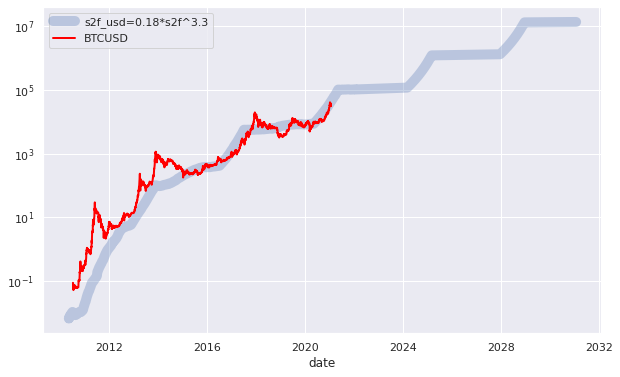

In [47]:
dfm.s2f_usd[500:].plot(label=f's2f_usd={S2F_FORMULA}',linewidth=10,alpha=0.3)
dfm.PriceUSD[500:].plot(label='BTCUSD',linewidth=2,color='red')
plt.yscale("log")
plt.grid(True)
plt.legend()

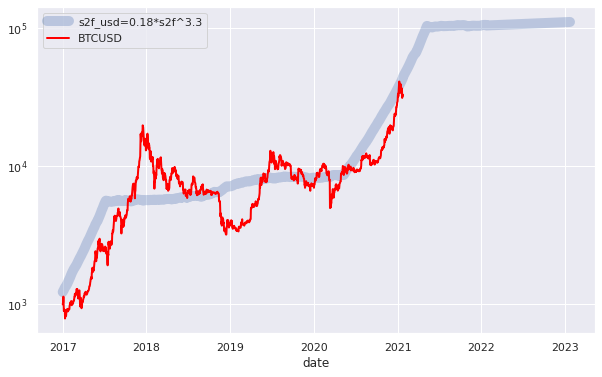

In [53]:
s=365*8
e=-365*8
dfm.s2f_usd[s:e].plot(label=f's2f_usd={S2F_FORMULA}',linewidth=10,alpha=0.3)
dfm.PriceUSD[s:e].plot(label='BTCUSD',linewidth=2,color='red')
plt.yscale("log")
plt.grid(True)
plt.legend()

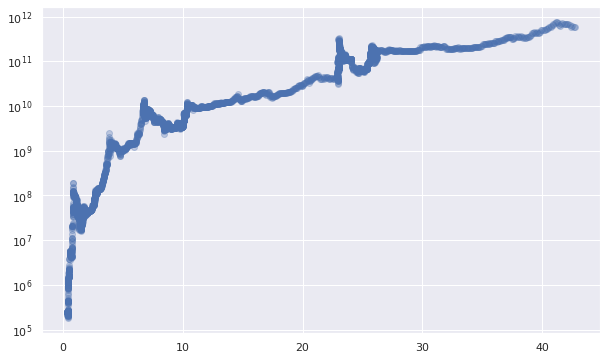

In [33]:
plt.scatter(dfm.s2f[500:],dfm.PriceUSD[500:]*dfm.SplyCur[500:],alpha=0.3)
plt.yscale("log")